<center> <h1> Brain Tumor Classification </h1></center>

The dataset that is used consists of Brain MRI images. The images belong to 4 classes:
1. Glioma Tumor
2. Meningioma Tumor
3. No Tumor
4. Pituitary Tumor

The task is to perform classification on the Brain MRI images.

In [1]:
!git clone https://github.com/kvarun07/brain-tumor-classifier.git

fatal: destination path 'brain-tumor-classifier' already exists and is not an empty directory.


### Import Libraries 

Let us first import the required libraries...

In [2]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB1

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Conv2D,Dropout,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import imutils    


### Setting up GPU environment

In [3]:
print(tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
))
tf.config.list_physical_devices('GPU')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
!nvidia-smi

Mon Jun  7 11:54:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    77W / 149W |    122MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Creating Directories to store Cropped Images

In [ ]:
# Create Directory for Training Data
os.mkdir('/content/brain-tumor-classifier/Brain-MRI-cropped')
os.mkdir('/content/brain-tumor-classifier/Brain-MRI-cropped/glioma_tumor')
os.mkdir('/content/brain-tumor-classifier/Brain-MRI-cropped/meningioma_tumor')
os.mkdir('/content/brain-tumor-classifier/Brain-MRI-cropped/no_tumor')
os.mkdir('/content/brain-tumor-classifier/Brain-MRI-cropped/pituitary_tumor')

In [ ]:
# Create Directory for Testing Data
os.mkdir('/content/brain-tumor-classifier/Brain-MRI-test')
os.mkdir('/content/brain-tumor-classifier/Brain-MRI-test/glioma_tumor')
os.mkdir('/content/brain-tumor-classifier/Brain-MRI-test/meningioma_tumor')
os.mkdir('/content/brain-tumor-classifier/Brain-MRI-test/no_tumor')
os.mkdir('/content/brain-tumor-classifier/Brain-MRI-test/pituitary_tumor')

In [ ]:
# Create Directory to store model curves
os.mkdir('/content/brain-tumor-classifier/assets')

### Data Visualisation

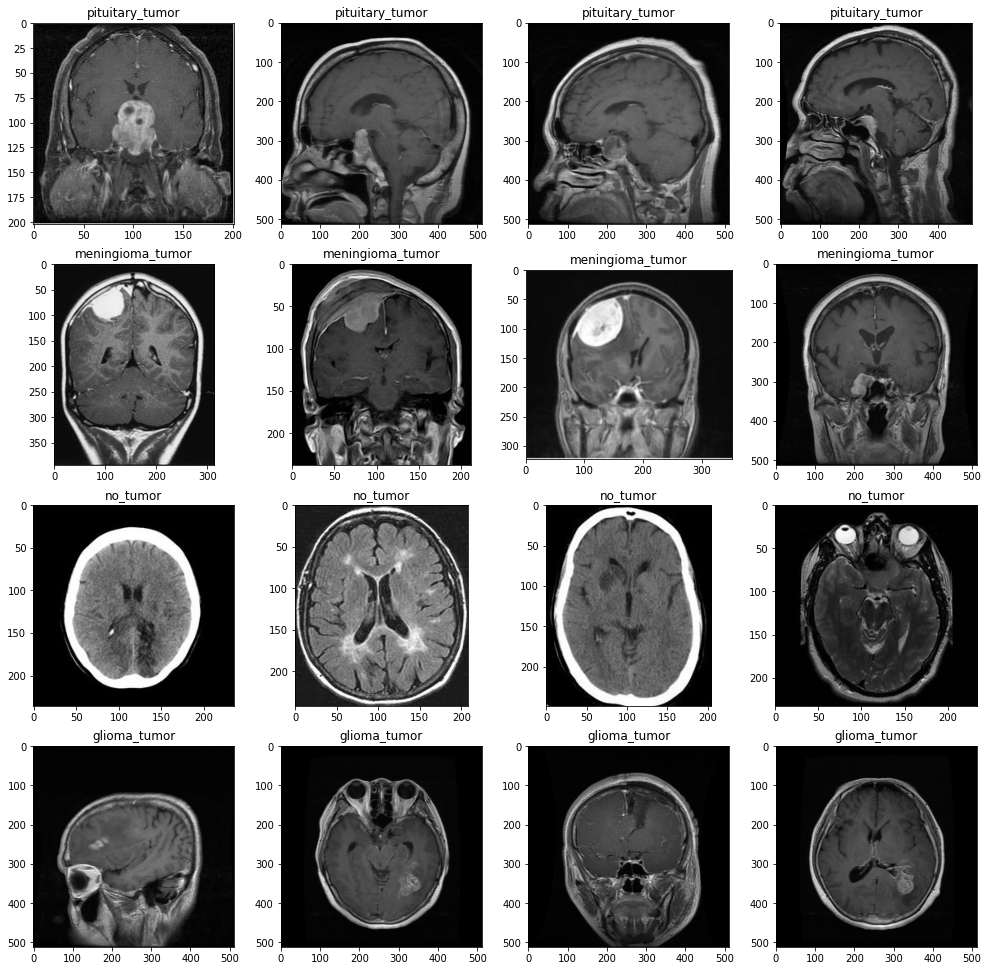

In [5]:
train_dir = '/content/brain-tumor-classifier/Brain-MRI-images/Training/'
test_dir = '/content/brain-tumor-classifier/Brain-MRI-images/Testing/'

classes = os.listdir(train_dir)
files_path_dict = {}

for i in classes:
    files_path_dict[i] = list(map(lambda x: train_dir+i + '/' + x, os.listdir(train_dir+i)))

plt.figure(figsize=(17,17))
index=0

# Plotting 4 random images from each class
for i in classes:
    random.shuffle(files_path_dict[i])
    path_list = files_path_dict[i][:5]
    
    for j in range (1,5):
        index += 1
        plt.subplot(4, 4, index)
        plt.imshow(load_img(path_list[j]))
        plt.title(i)
        
        

### Create a Function to Crop Images

It can be clearly observed from the above sample images that every brain MRI scan has a surrounding black area. So, this black portion is redundant for the classification prpblem since it does not form a distinguishing feature for any class. \
We can crop this black portion out of the brain MRI images.

In [6]:
def crop_image(image, plot=False):
    
    # Conversion to grayscale, followed by blurring
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]
    img_thresh = cv2.erode(img_thresh, None, iterations=2)
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image


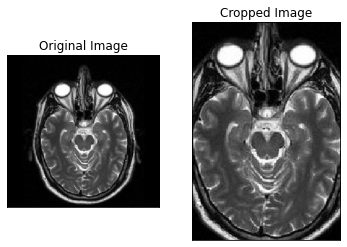

In [7]:
# Sample to compare the cropped image with respect to the original image.
sample_class = random.randint(0,3)
class_list = list(files_path_dict.values())

sample_image_no = random.randint(0, len(class_list[sample_class])-1)
sample_path = class_list[sample_class][sample_image_no]

sample_image = cv2.imread(sample_path)
cropped_image = crop_image(sample_image, plot=True)

### Saving The Cropped Images 

In [8]:
# Cropping the Training Images and Saving to the directory created

glioma = train_dir + "glioma_tumor"
meningioma = train_dir + "meningioma_tumor"
no_tumor = train_dir + "no_tumor"
pituitary = train_dir + "pituitary_tumor"

tumor_train_dict = {glioma: "glioma_tumor" , meningioma: "meningioma_tumor", no_tumor: "no_tumor", pituitary: "pituitary_tumor"}

for tumor in tumor_train_dict:
    j = 0
    for i in tqdm(os.listdir(tumor)):
        path = os.path.join(tumor, i)
        img = cv2.imread(path)
        img = crop_image(img, plot=False)
        
        if img is not None:
            img = cv2.resize(img, (224, 224))
            save_path = '/content/brain-tumor-classifier/Brain-MRI-cropped/' + tumor_train_dict[tumor] + "/" + str(j) + ".jpg"
            cv2.imwrite(save_path, img)
            j += 1

    

100%|██████████| 901/901 [00:06<00:00, 148.70it/s]


In [9]:
# Cropping the Test Images and Saving to the directory created

glioma = test_dir + "glioma_tumor"
meningioma = test_dir + "meningioma_tumor"
no_tumor = test_dir + "no_tumor"
pituitary = test_dir + "pituitary_tumor"

tumor_test_dict = {glioma: "glioma_tumor" , meningioma: "meningioma_tumor", no_tumor: "no_tumor", pituitary: "pituitary_tumor"}

for tumor in tumor_test_dict:
    j=0
    for i in tqdm(os.listdir(tumor)):
        path = os.path.join(tumor, i)
        img = cv2.imread(path)
        img = crop_image(img, plot=False)
        
        if img is not None:
            img = cv2.resize(img, (224, 224))
            save_path = '/content/brain-tumor-classifier/Brain-MRI-test/' + tumor_test_dict[tumor] + "/" + str(j) + ".jpg"
            cv2.imwrite(save_path, img)
            j += 1

100%|██████████| 5/5 [00:00<00:00, 106.03it/s]


### Perform Data Augmentation and Prepare the Train, Validation and Test Dataset

In [10]:
# Using Image Data Generator to perform this task

datagen = ImageDataGenerator(rotation_range=10, 
                             height_shift_range=0.2, 
                             horizontal_flip=True,
                             validation_split=0.2)

train_data=datagen.flow_from_directory('/content/brain-tumor-classifier/Brain-MRI-cropped/',
                                       target_size=(224, 224),
                                       batch_size=16,
                                       class_mode='categorical',
                                       subset='training')

validation_data = datagen.flow_from_directory('/content/brain-tumor-classifier/Brain-MRI-cropped/',
                                             target_size=(224, 224),
                                             batch_size=16,
                                             class_mode='categorical',
                                             subset='validation')

test_datagen = ImageDataGenerator()

test_data = test_datagen.flow_from_directory('/content/brain-tumor-classifier/Brain-MRI-test/',
                                        target_size=(224,224),
                                       class_mode='categorical')

Found 4476 images belonging to 4 classes.
Found 1117 images belonging to 4 classes.
Found 35 images belonging to 4 classes.


In [11]:
# View the class dictionary

print(train_data.class_indices)
print(test_data.class_indices)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


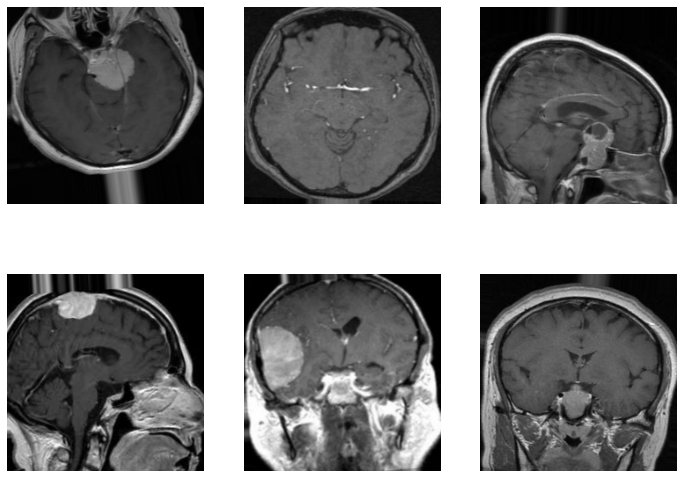

In [12]:
# View the augmented data.
sample_x, sample_y = next(train_data)
plt.figure(figsize=(12,9))

for i in range(6):
    plt.subplot(2, 3, i+1)
    sample = array_to_img(sample_x[i])
    plt.axis('off')
    plt.grid(False)
    plt.imshow(sample)
    
plt.show()

### Build and Compile the Model 

In [13]:
# Build the EfficientNet Model

# Efficient Net does not have a lot of paramters but manages to give fairly high accuracy
# Effnet is pre-trained on 'imagenet' dataset
effnet = EfficientNetB1(weights="imagenet", include_top=False, input_shape=(224,224,3))

# Add new layers on top of the effnet model
model = effnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)              # Avoid overfitting
model = Dense(4, activation='softmax')(model)
model = Model(inputs=effnet.input, outputs=model)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [14]:
# Compiling the model

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint("/content/brain-tumor-classifier/tumor_model.h5", monitor='val_accuracy', save_best_only=True, mode='auto', verbose=1)
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, mode='auto', verbose=1)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### Model Training and Model Evaluation

In [15]:
# Train the model

history = model.fit(train_data, epochs=7, validation_data=validation_data, verbose=1, callbacks=[checkpoint, earlystop])


Epoch 1/7
280/280 [==============================] - 158s 506ms/step - loss: 0.5737 - accuracy: 0.7878 - val_loss: 0.3853 - val_accuracy: 0.8684

Epoch 00001: val_accuracy improved from -inf to 0.86840, saving model to /content/brain-tumor-classifier/tumor_model.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/7
280/280 [==============================] - 138s 493ms/step - loss: 0.2115 - accuracy: 0.9321 - val_loss: 0.1697 - val_accuracy: 0.9454

Epoch 00002: val_accuracy improved from 0.86840 to 0.94539, saving model to /content/brain-tumor-classifier/tumor_model.h5
Epoch 3/7
280/280 [==============================] - 137s 489ms/step - loss: 0.1200 - accuracy: 0.9631 - val_loss: 0.0928 - val_accuracy: 0.9749

Epoch 00003: val_accuracy improved from 0.94539 to 0.97493, saving model to /content/brain-tumor-classifier/tumor_model.h5
Epoch 4/7
280/280 [==============================] - 137s 488ms/step - loss: 0.0839 - accuracy: 0.9712 - val_loss: 0.0713 - val_accuracy: 0.9776

Epoch 00004: val_accuracy improved from 0.97493 to 0.97762, saving model to /content/brain-tumor-classifier/tumor_model.h5
Epoch 5/7
280/280 [==============================] - 138s 493ms/step - loss: 0.0773 - accuracy: 0.9759 - val_loss: 0.0411 - val_accuracy: 0.9884

Epoch 00005: val_accuracy improved from 0.97762

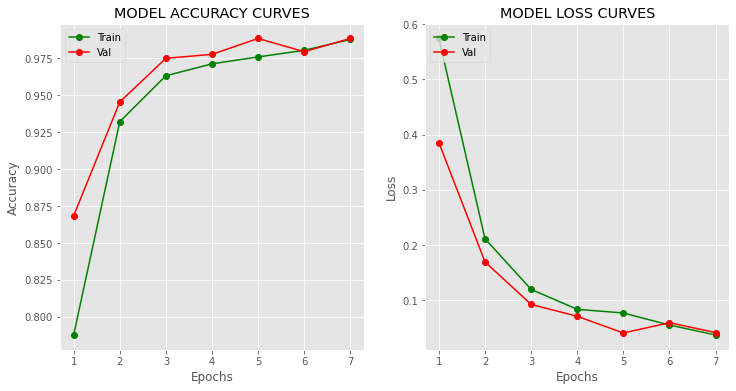

In [16]:
# Plot the training curves

plt.style.use('ggplot')
plt.figure(figsize=(12,6))
epochs=range(1,8)

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], 'go-')
plt.plot(epochs, history.history['val_accuracy'], 'ro-')
plt.title('MODEL ACCURACY CURVES')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], 'go-')
plt.plot(epochs, history.history['val_loss'], 'ro-')
plt.title('MODEL LOSS CURVES')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')

plt.savefig('/content/brain-tumor-classifier/assets/model_curves.png')

plt.show()

In [17]:
# Evaluate the model on Test Set

model.evaluate(test_data)

2/2 [==============================] - 2s 596ms/step - loss: 0.2457 - accuracy: 0.9714


[0.24569816887378693, 0.9714285731315613]

### Obtaining Predictions on Test Images

The MRI scan belongs to the class: glioma_tumor


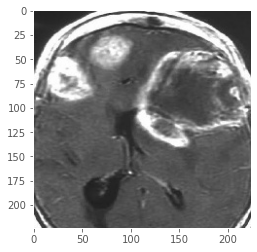

In [18]:
# Obtain Predictions on Test Images

class_dict = {0: 'glioma_tumor', 1: 'meningioma_tumor', 2: 'no_tumor', 3: 'pituitary_tumor'}

# Pick some sample image from a known category of brain tumor
# check the corresponding model prediction
test_image_1 = cv2.imread('/content/brain-tumor-classifier/Brain-MRI-test/glioma_tumor/2.jpg')
plt.imshow(test_image_1)
plt.grid(False)
test_image_1 = np.expand_dims(test_image_1, axis=0)
pred = model.predict(test_image_1)
pred = np.argmax(pred)
pred_class = class_dict[pred]

print("The MRI scan belongs to the class:", pred_class)